In [16]:
from unittest import result
from koala.pointsets import generate_random
from matplotlib import pyplot as plt
import numpy as np
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.hamiltonian import generate_majorana_hamiltonian
from koala.flux_finder import find_flux_sector
import pickle as pkl
import os
from tqdm import tqdm
from koala import plotting as pl

In [93]:
metaparam_location = '/Users/perudornellas/python/imperial/cx1_am_kit/state_scaling/systems.pickle'
results_location = '/Users/perudornellas/python/imperial/cx1_am_kit/state_scaling/results/'

# load parameters
lattices = []
colorings = []
gnd_ujk_values = []
with open(metaparam_location, 'rb') as f_param:

        # load the metaparameters
        metaparmeters = pkl.load(f_param)
        points_max = metaparmeters['max_points']
        j_vals = metaparmeters['j_vals'] 
        scales = metaparmeters['scales']
        q_powers = metaparmeters['q_powers']

        # load the lattices
        for n in range(len(scales)):
                lattice, coloring, gnd_ujk, s = pkl.load(f_param)
                lattices.append(lattice)
                colorings.append(coloring)
                gnd_ujk_values.append(gnd_ujk)


energy_limit = 1.5
bins = 500
bin_regions = np.linspace(-1.5,1.5,bins+1)
bin_size = 2*energy_limit/bins
energy_centers = bin_regions[:-1] + bin_size/2
file_names = [name for name in os.listdir(results_location) if name[0]!= '.']
n_files = len(file_names)
print(n_files)

1016


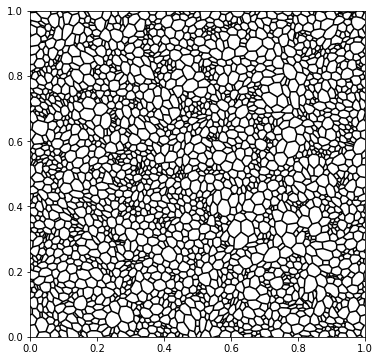

In [94]:

lattice_example_index = 499
fig, ax = plt.subplots(figsize = (6,6))
pl.plot_edges(lattices[lattice_example_index])
plt.show()


In [95]:
all_participations = np.zeros([n_files,len(scales) ,bins, len(q_powers)])

for f_num,filename in enumerate(tqdm(file_names)):

    individual_participations = np.zeros([len(scales) ,bins, len(q_powers)])
    with open(results_location + filename, 'rb') as f:

        for n, s in enumerate(scales):

            x = pkl.load(f)

            assert(x['system_index'] == n)
            energies = x['energies']

            participations = x['participation_ratios']
            energies_binned = (energies+energy_limit)//bin_size
            
            for u in range(bins):
                indx = np.where(energies_binned == u)[0]
                num_in_indx = len(indx)
                if num_in_indx == 0:
                    continue
                averaged_p = np.average(participations[indx], axis= 0)


                individual_participations[n,u] =  averaged_p
    
    all_participations[f_num] = individual_participations


  1%|          | 8/1016 [00:14<29:56,  1.78s/it]

In [42]:
all_participations[all_participations == 0] = np.nan
averaged_participations = np.average(all_participations, axis = 0)

(200, 5)


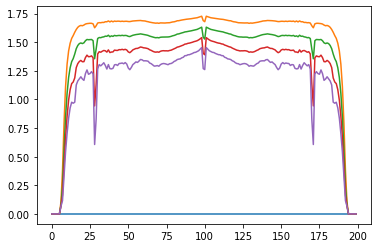

In [92]:
index = 100
shown = 0
gradients = np.zeros([bins, len(q_powers)])
for index in range(bins):
    for nq in range(len(q_powers)):
        idx = np.isfinite(averaged_participations[:,index,nq])
        if np.sum(idx)>1:
            p = np.polyfit(np.log(scales[idx]), np.log(averaged_participations[idx,index,nq]) , 1)
            gradients[index, nq] = p[0]

print(gradients.shape)
dq = -gradients[:,:]/(q_powers[:] - 0.99999)

plt.plot(dq)